See http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html





















Loss:   0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


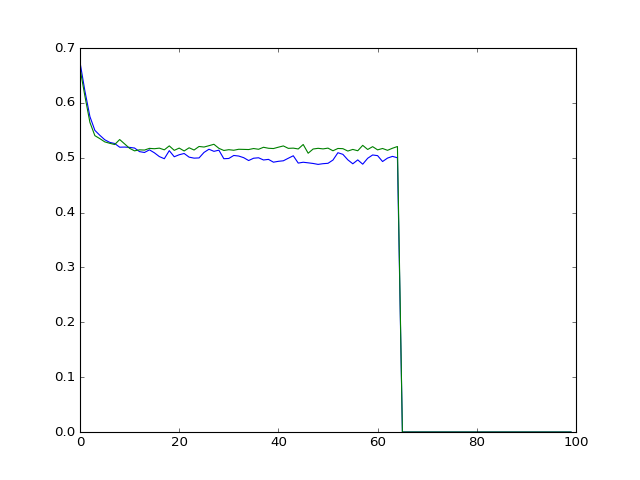

KeyboardInterrupt: 

In [21]:
from rnn import *
from tqdm import tqdm_notebook as tn
from tqdm import tqdm, trange

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# best settings:
#model = RNN(rnn_type ='GRU', nf=2, nh=25, nlay=3, dropout = 0.5)
#model = RNN(rnn_type ='GRU', nf=2, nh=10, nlay=1, dropout = 0.1) # BEST!! final test loss = 0.48
#model = RNN(rnn_type ='LSTM', nf=2, nh=16, nlay=1, dropout = 0.0) # 0.47 !

model = RNN(rnn_type ='GRU', nf=2, nh=16, nlay=2, dropout = 0.01) 



#loss_fn = nn.MSELoss(size_average=True)
loss_fn = nn.BCELoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr = 0.1)
#optimizer = optim.Adam(model.parameters(), lr = 0.7)
#optimizer = optim.RMSprop(model.parameters(), lr = 0.001)
model.zero_grad()

var_x, var_y, lengths, xtest, ytest, test_lens = make_r2rt_data(50, 1000, 1, gpu = True, xhot = True)
## manually run model a few iterations
model.cuda()

bsiz = 100 # mini-batches of 50 sequences at a time
nb = var_x.data.size()[1]/bsiz  # how many mini-batches per epoch

nepochs = 100
loss = 1.0
epoch_range = trange(nepochs, desc='Loss', leave=True)
    
points = np.zeros(nepochs) # train losses
val_points = np.zeros(nepochs) # validation losses

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for epoch in range(nepochs):
    for batch in range(nb):
        bStart = batch * bsiz
        bEnd = min(var_x.size()[1], (batch + 1)*bsiz)
        hidden = model.init_hidden(bsiz)
        hidden = repackage_hidden(hidden)
        model.zero_grad()
        optimizer.zero_grad()
        batch_x = var_x[:, bStart : bEnd, :]
        batch_lengths = lengths[bStart : bEnd]
        batch_x_packed = rnn_utils.pack_padded_sequence(batch_x, batch_lengths)
        y_pred, hidden = model(batch_x_packed, hidden)
        batch_y = rnn_utils.pack_padded_sequence(var_y[:, bStart : bEnd, :], batch_lengths)
        # CAUTION -- y_pred is BATCH-WISE, i.e. b
        # batch 0 for ALL sequences, then
        # batch 2 for ALL sequences, etc.
        # target = var_y.squeeze()[:, bStart:bEnd].contiguous().view(-1, 1)
        loss = loss_fn(y_pred, batch_y.data)
        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # tqdm.write('loss = ' + str(loss.data[0]))
    points[epoch] = loss.data[0]
    val_loss = loss_fn(model(xtest, None)[0], ytest).data[0]
    val_points[epoch] = val_loss
    ax.clear()
    ax.plot(points)
    ax.plot(val_points)
    fig.canvas.draw()
#     epoch_range.set_description("Loss %4.3f" % loss.data[0])
#     epoch_range.refresh() # to show immediately the update


print 'val loss = ', val_loss


# print 'y,pred = ', zip(batch_y.data.squeeze()[:ny].data.cpu().numpy(), y_pred.data.squeeze()[:ny].cpu().numpy())
